In [9]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.patches import *
import numpy as np
from pylab import *
from numpy import ma
%matplotlib inline

In this notebook, the numerical solution using front tracking method for the movement of a droplet inside a liquid flow will be presented.
Firstly, let us present the solution for a droplet in a closed box. The scheme to solve this problem has been presented in Tryggvason's tutorial and will not be represented here. The following code is the implementation of his MATLAB code into Python. Minor modifications were made to enable array calculation and make front tracking part compatible with Python.

In [10]:
def makegraph(x,y,u,v,nx,ny,dx,dy,xf,yf,Nf,r,steps):
    fig = plt.figure(figsize=(6,6), dpi=300)
    uu=0.5*(u[0:nx,1:ny+1]+u[0:nx,0:ny])
    vv=0.5*(v[1:nx+1,0:ny]+v[0:nx,0:ny])
    yy,xx=np.mgrid[0:(nx-1)*dx:nx*1j,0:(ny-1)*dx:ny*1j]
    plt.contourf(x,y,r.T,5)
    plt.colorbar
    plt.quiver(xx,yy,uu.T,vv.T)
    plt.plot(xf[0:Nf+1], yf[0:Nf+1],linewidth=5.0)
    plt.title('Time Step %s' %(steps))

In [11]:
def solvewall():
    #===============SETUP THE COMPUTATIONAL DOMAIN==================#
    
    #Set the grid
    dx=Lx/nx; dy=Ly/ny
    x=np.linspace(-dx/2,(nx+0.5)*dx,nx+2)
    y=np.linspace(-dy/2,(ny+0.5)*dy,ny+2)

    #Set density in domain and drop:
    r=np.ones((nx+2,ny+2))*rho1
    for i in range(1,nx+1):
        for j in range (1,ny+1):
            if ((x[i]-xc)**2+(y[j]-yc)**2)<rad**2:
                r[i,j]=rho2;

    #Zero arrays
    u=np.zeros((nx+1,ny+2)); v=np.zeros((nx+2,ny+1)); p=np.zeros((nx+2,ny+2))
    ut=np.zeros((nx+1,ny+2)); vt=np.zeros((nx+2,ny+1)); tmp1=np.zeros((nx+2,ny+2));
    uu=np.zeros((nx+1,ny+1)); vv=np.zeros((nx+1,ny+1)); tmp2=np.zeros((nx+2,ny+2))
    
    #================SETUP THE FRONT=====================#
    Nf=100;
    xf=np.zeros((Nf+2)); yf=np.zeros((Nf+2))
    for i in range(Nf+1):
        xf[i]=xc-rad*sin(2.0*np.pi*i/Nf);
        yf[i]=yc+rad*cos(2.0*np.pi*i/Nf);
    
    #fig = plt.figure(figsize=(15,22.5), dpi=300)
    plotcount=0
        
    #===============START THE TIME LOOP==================#
    
    for steps in range (nstep):
        fx=np.zeros((nx+2,ny+2)); fy=np.zeros((nx+2,ny+2))

        #Tangential at boundaries: (Dieter's code is not correct at the part u[:,-1])
        u[:,0]=2*usouth-u[:,1];u[:,nx+1]=2*unorth-u[:,ny];
        v[0,:]=2*vwest-v[1,:];v[ny+1,:]=2*veast-v[nx,:];

        #Temporary u-velocity
        ut[1:-1,1:-1]=u[1:-1,1:-1]+dt*(-0.25*(((u[2:,1:-1]+u[1:-1,1:-1])**2-(u[1:-1,1:-1]+u[0:-2,1:-1])**2)/dx+\
                                              ((u[1:-1,2:]+u[1:-1,1:-1])*(v[2:-1,1:]+v[1:-2,1:])-\
                                               (u[1:-1,1:-1]+u[1:-1,0:-2])*(v[2:-1,0:-1]+v[1:-2,0:-1]))/dy)+\
                                       m0/(0.5*(r[2:-1,1:-1]+r[1:-2,1:-1]))*\
                                       ((u[2:,1:-1]-2*u[1:-1,1:-1]+u[0:-2,1:-1])/(dx**2)+\
                                        (u[1:-1,2:]-2*u[1:-1,1:-1]+u[1:-1,0:-2])/(dy**2))+gx)

        #Temporary v-velocity
        vt[1:-1,1:-1]=v[1:-1,1:-1]+dt*(-0.25*(((u[1:,2:-1]+u[1:,1:-2])*(v[2:,1:-1]+v[1:-1,1:-1])-\
                                               (u[0:-1,2:-1]+u[0:-1,1:-2])*(v[1:-1,1:-1]+v[0:-2,1:-1]))/dx+\
                                              ((v[1:-1,2:]+v[1:-1,1:-1])**2-(v[1:-1,1:-1]+v[1:-1,0:-2])**2)/dy)+\
                                       m0/(0.5*(r[1:-1,2:-1]+r[1:-1,1:-2]))*\
                                       ((v[2:,1:-1]-2*v[1:-1,1:-1]+v[0:-2,1:-1])/(dx**2)+\
                                        (v[1:-1,2:]-2*v[1:-1,1:-1]+v[1:-1,0:-2])/(dy**2))+gy)

        # Coefficient for p(i,j):
        rt=r.copy(); lrg=1000;
        rt[:,0]=lrg; rt[:,ny+1]=lrg;
        rt[0,:]=lrg; rt[nx+1,:]=lrg;

        tmp1[1:-1,1:-1]=(0.5/dt)*((ut[1:,1:-1]-ut[0:-1,1:-1])/dx+(vt[1:-1,1:]-vt[1:-1,0:-1])/dy)
        tmp2[1:-1,1:-1]=1.0/((1./dx)*(1./(dx*(rt[2:,1:-1]+rt[1:-1,1:-1]))+\
                                      1./(dx*(rt[0:-2,1:-1]+rt[1:-1,1:-1])))+\
                             (1./dy)*(1./(dy*(rt[1:-1,2:]+rt[1:-1,1:-1]))+\
                                     1./(dy*(rt[1:-1,0:-2]+rt[1:-1,1:-1]))))

        # Poisson solver for p:
        iter=0
        while True:
            pn=p.copy()
            iter=iter+1
            for i in range(1,nx+1):
                for j in range(1,ny+1):
                    p[i,j]=(1.0-beta)*p[i,j]+beta*tmp2[i,j]*(\
                        (1./dx)*( p[i+1,j]/(dx*(rt[i+1,j]+rt[i,j]))+\
                        p[i-1,j]/(dx*(rt[i-1,j]+rt[i,j])))+\
                        (1./dy)*( p[i,j+1]/(dy*(rt[i,j+1]+rt[i,j]))+\
                        p[i,j-1]/(dy*(rt[i,j-1]+rt[i,j])))-tmp1[i,j])

            if np.abs(pn-p).max()<maxError:
                break
            if iter>maxiter:
                break

        #Calculate u-velocity:
        u[1:-1,1:-1]=ut[1:-1,1:-1]-dt*(2.0/dx)*(p[2:-1,1:-1]-p[1:-2,1:-1])/(r[2:-1,1:-1]+r[1:-2,1:-1])


        #Calculate v-velocity:
        v[1:-1,1:-1]=vt[1:-1,1:-1]-dt*(2.0/dy)*(p[1:-1,2:-1]-p[1:-1,1:-2])/(r[1:-1,2:-1]+r[1:-1,1:-2])


        #===============FRONT TRACKING AND DENSITY DISTRIBUTION==================#
        
        #Calculate front velocity:
        uf=np.zeros((Nf+2)); vf=np.zeros((Nf+2))

        for i in range (1,Nf+1):

            #Calculate x-component
            ip=floor(xf[i]/dx); jp=floor((yf[i]+0.5*dy)/dy);
            ax=xf[i]/dx-ip; ay=(yf[i]+0.5*dy)/dy-jp;
            uf[i]=(1.0-ax)*(1.0-ay)*u[ip,jp]+ax*(1.0-ay)*u[ip+1,jp]+(1.0-ax)*ay*u[ip,jp+1]+ax*ay*u[ip+1,jp+1]

            #Calculate y-component
            ip=floor((xf[i]+0.5*dx)/dx); jp=floor(yf[i]/dy)
            ax=(xf[i]+0.5*dx)/dx-ip;ay=yf[i]/dy-jp
            vf[i]=(1.0-ax)*(1.0-ay)*v[ip,jp]+ax*(1.0-ay)*v[ip+1,jp]+(1.0-ax)*ay*v[ip,jp+1]+ax*ay*v[ip+1,jp+1]

        #Move the front:
        for i in range (1,Nf+1):
            xf[i]=xf[i]+uf[i]*dt;yf[i]=yf[i]+vf[i]*dt

        xf[0]=xf[Nf]; yf[0]=yf[Nf]; xf[Nf+1]=xf[1]; yf[Nf+1]=yf[1]

        # Add points to the front
        xfold=xf.copy(); yfold=yf.copy(); j=0;
        xf1=[]; xf1.append(xf[0]);
        yf1=[]; yf1.append(yf[0]);
        for i in range (1,Nf+1):
            ds=sqrt(((xfold[i]-xf1[j])/dx)**2+((yfold[i]-yf1[j])/dy)**2);
            if ds>0.5:
                j=j+1;xf1.append(0.5*(xfold[i]+xf1[j-1]));yf1.append(0.5*(yfold[i]+yf1[j-1]))
                j=j+1;xf1.append(xfold[i]);yf1.append(yfold[i])
            elif ds>0.25:
                j=j+1;xf1.append(xfold[i]);yf1.append(yfold[i])

        Nf=j-1; xf=np.asarray(xf1);yf=np.asarray(yf1)
        xf[0]=xf[Nf];yf[0]=yf[Nf]
        xf[Nf+1]=xf[1];yf[Nf+1]=yf[1]

        #Distribute gradient:
        fx=np.zeros((nx+2,nx+2)); fy=np.zeros((nx+2,ny+2))
        for i in range (1,Nf+1):
            nfx=-0.5*(yf[i+1]-yf[i-1])*(rho2-rho1)
            nfy=0.5*(xf[i+1]-xf[i-1])*(rho2-rho1)

            ip=floor(xf[i]/dx); jp=floor((yf[i]+0.5*dy)/dy);
            ax=xf[i]/dx-ip; ay=(yf[i]+0.5*dy)/dy-jp;
            fx[ip,jp] =fx[ip,jp]+(1.0-ax)*(1.0-ay)*nfx/dx/dy;
            fx[ip+1,jp] =fx[ip+1,jp]+ax*(1.0-ay)*nfx/dx/dy;
            fx[ip,jp+1] =fx[ip,jp+1]+(1.0-ax)*ay*nfx/dx/dy;
            fx[ip+1,jp+1]=fx[ip+1,jp+1]+ax*ay*nfx/dx/dy;

            ip=floor((xf[i]+0.5*dx)/dx); jp=floor(yf[i]/dy);
            ax=(xf[i]+0.5*dx)/dx-ip; ay=yf[i]/dy-jp;
            fy[ip,jp] =fy[ip,jp]+(1.0-ax)*(1.0-ay)*nfy/dx/dy;
            fy[ip+1,jp] =fy[ip+1,jp]+ax*(1.0-ay)*nfy/dx/dy;
            fy[ip,jp+1] =fy[ip,jp+1]+(1.0-ax)*ay*nfy/dx/dy;
            fy[ip+1,jp+1]=fy[ip+1,jp+1]+ax*ay*nfy/dx/dy;

        #Construct the density
        iter=0
        while True:
            rt=r.copy()
            iter=iter+1
            r[1:-1,1:-1]=0.25*(r[2:,1:-1]+r[0:-2,1:-1]+r[1:-1,2:]+r[1:-1,0:-2]+
                              dx*(fx[0:-2,1:-1]-fx[1:-1,1:-1])+ dy*(fy[1:-1,0:-2]-fy[1:-1,2:]))
            if np.abs(rt-r).max()<maxError:
                break
            if iter>maxiter:
                break
        
        #===============PLOTTING==================#
        if (steps >= nstep/10*(plotcount) and steps < nstep/10*(plotcount)+1) or steps==nstep-1:
            makegraph(x,y,u,v,nx,ny,dx,dy,xf,yf,Nf,r,steps)
            plotcount=plotcount+1
        
        plt.show()
        

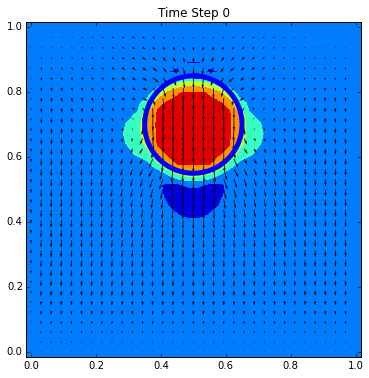

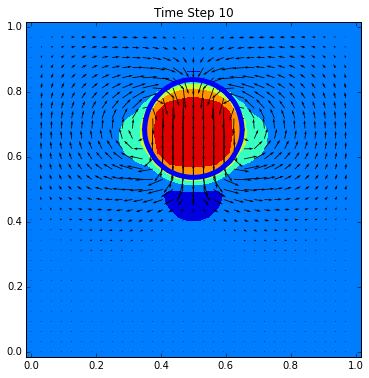

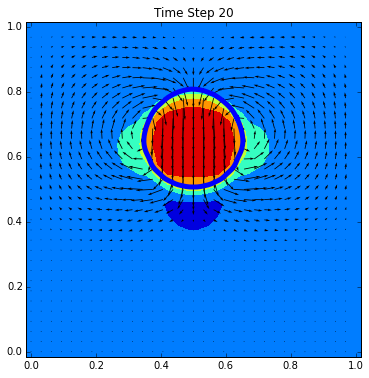

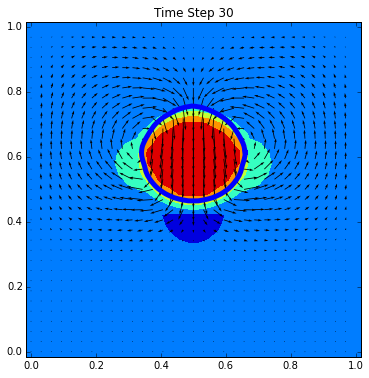

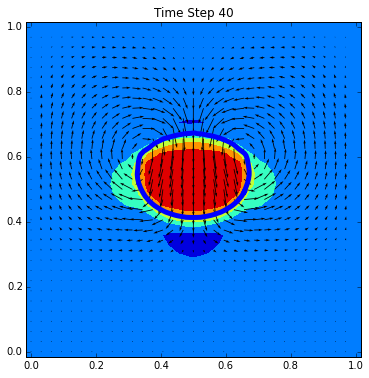

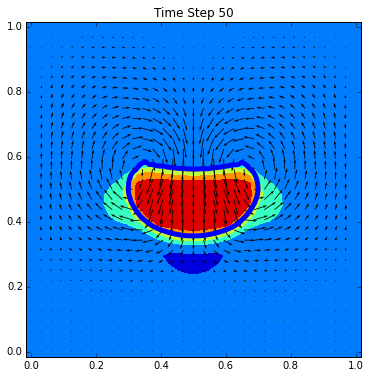

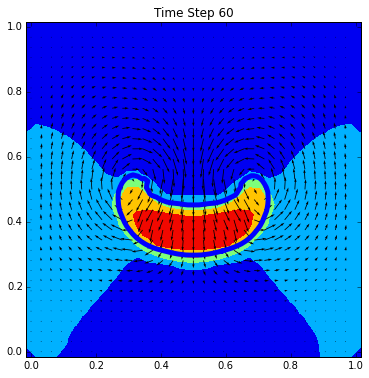

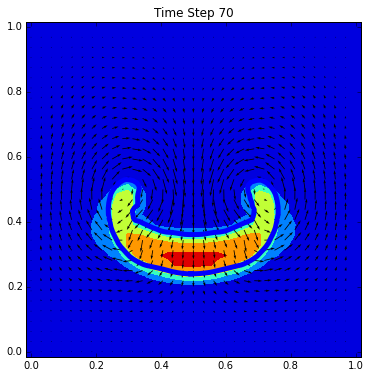

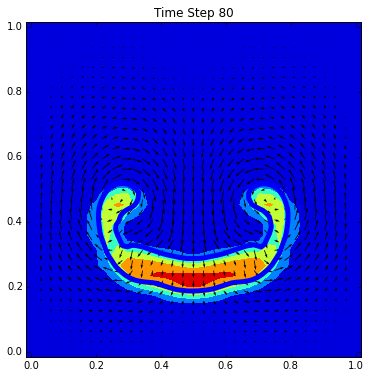

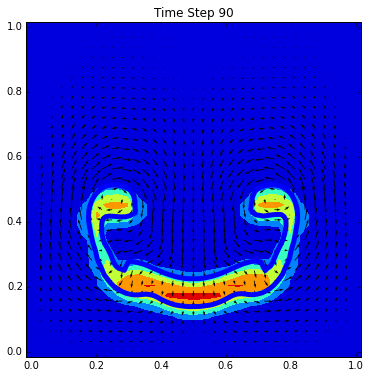

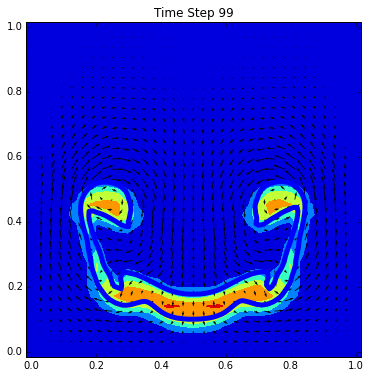

In [12]:
#Domain size and constant parameters
Lx=1.0; Ly=1.0
gx=0.0; gy=-100.0;
rho1=1.0; rho2=2.0
m0=0.01;
rro=rho1;


#Velocity at wall boundary
unorth=0; usouth=0; veast=0; vwest=0; 

#Initial drop size and location
time=0.0; rad=0.15; xc=0.5; yc=0.7;

#Numerical variables
nx=32; ny=32;
dt=0.0025; nstep=100
maxiter=200; maxError=0.001
beta=1.2;

solvewall()

#Periodic boundary condition
For periodic boundary condition, some modifications need to be made at the boundary conditions $y=0$ and $y=Lx$. Boundary conditions at $x=0$ and $x=Lx$, as well as the domain equations remain unchanged.

##Pressure and velocity

For pressure $p$ and horizontal velocity $u$, periodic boundary condition means applying the values at the physical top/bottom cells to the bottom/top ghost cells respectively. This yields:

$$
\begin{equation*}
p_{i,0}=p_{i,ny}
\tag{1}\end{equation*}
$$

$$
\begin{equation*}
p_{i,ny+1}=p_{i,1}
\tag{2}\end{equation*}
$$

and

$$
\begin{equation*}
u_{i+1/2,0}=u_{i+1/2,ny}
\tag{3}\end{equation*}
$$

$$
\begin{equation*}
u_{i+1/2,ny+1}=u_{i+1/2,1}
\tag{4}\end{equation*}
$$

For vertical velocity $v$, we have to derive it from the beginning using Tryggvason's method. Step-by-step to numerically derive the vertical velocity have been provided in his note and will not be repeated here. At the periodic boundary, the only difference in the derivation is that when calculating $v_{i, 1/2}$, the term $v_{i,j-1/2}$ is replaced by $v_{i,ny+1/2}$ and when calculating $v_{i,ny+1/2}$, the term $v_{i,j+1/2}$ is replaced with $v_{i,1/2}$

##Density and front surface

For density, similar to pressure, periodic boundary condition is realized by applying the density of the bottom/top ghost cells to the physical top/bottom ghost cells respectively.

$$
\begin{equation*}
r_{i,0}=r_{i,ny}
\tag{5}\end{equation*}
$$

$$
\begin{equation*}
r_{i,ny+1}=r_{i,0}
\tag{6}\end{equation*}
$$

For the front surface, we want to make the body of the droplet that leaves the domain at the bottom re-appear near the top. In order to do that, a constraint is imposed to the y-coordinate of the droplet's front surface that if $y_{front}<0$ then $y_{front}=y_{front}+L_{y}$.

##Body forces

Periodic boundary condition will make the whole system, i.e the droplet and the surrounding fluid, free falls as if it is staying inside a infinite vertical tube. The result is that the droplet maintains its circular shape during the falling process. However, the aim of the simulation is to investigate the fall of a droplet in a stationary long tube. To prevent the fluid from free falling, a body force need to be applied to the whole domain to balance gravity. The gravity term is now expressed as: $\frac{\rho-\rho_1}{\rho}\textbf{g}$ where $\rho$ is the density of the current cell and $\rho_1$ is the density of the fluid. With this effective gravity, the droplet, having higher density, will fall while surrounding fluid remains stable.


##Surface tension

As can be seen from the simulation of the wall problem, the droplet deforms significantly before it even reaches the bottom. The reason is that no surface tension is implemented as a restoring force, so the droplet will just dissolve to the liquid. In order to help the bubble maintains its shape long enough for the falling, a surface tension needs to be applied. For that reason, we will construct the simulation in the same manner as what is discussed in Tryggvason's tutorial, Chapter 4.

## Frame shift

If the droplet undergoes free fall, eventually it will fall out of the frame. We understand that the aim of the periodic boundary condition is to make the drop reappear at the top once it falls out of the bottom. However, doing so will complicate the code (especially in the part of reconstructing the front and creates density distribution) and causes numerical instability. To resolve this, we decide  to maintain the position of the droplet at the center of the domain and shift the whole frame instead. To be more specific, if the center of the physcial displacement of the droplet is $\Delta y$, then the whole domain will be shifted by $\Delta y$. The part of the domain that falls out of the frame will reaappear at the top. With this, the center position of the droplet is ensured. This method is thanks to the discussion with our class member Qing Yun.

In [13]:
def solveperiodic():
    #===============SETUP THE COMPUTATIONAL DOMAIN==================#
    
    #Set the grid
    dx=Lx/nx; dy=Ly/ny
    x=np.linspace(-dx/2,(nx+0.5)*dx,nx+2)
    y=np.linspace(-dy/2,(ny+0.5)*dy,ny+2)

    #Set density and viscosity in domain and drop:
    r=np.ones((nx+2,ny+2))*rho1
    m=np.ones((nx+2,ny+2))*m1
    rn=np.zeros((nx+2,ny+2))
    mn=np.zeros((nx+2,ny+2))   # second order
    for i in range (1,nx+1):
        for j in range (1,ny+1):
            if ((x[i]-xc)**2+(y[j]-yc)**2)<rad**2:
                r[i,j]=rho2
                m[i,j]=m2
                
    #Zero arrays
    u=np.zeros((nx+1,ny+2)); v=np.zeros((nx+2,ny+1)); p=np.zeros((nx+2,ny+2))
    ut=np.zeros((nx+1,ny+2)); vt=np.zeros((nx+2,ny+1)); tmp1=np.zeros((nx+2,ny+2));
    uu=np.zeros((nx+1,ny+1)); vv=np.zeros((nx+1,ny+1)); tmp2=np.zeros((nx+2,ny+2))
    
    #Setup the bubble front
    Nf=100;
    xf=np.zeros(Nf+2)
    yf=np.zeros(Nf+2)
    xfn=np.zeros(Nf+2)
    yfn=np.zeros(Nf+2)   # second order
    uf=np.zeros(Nf+2)
    vf=np.zeros(Nf+2)
    tx=np.zeros(Nf+2)
    ty=np.zeros(Nf+2)
    
    for i in range(Nf+1):
        xf[i]=xc-rad*sin(2.0*np.pi*i/Nf);
        yf[i]=yc+rad*cos(2.0*np.pi*i/Nf);
        
    plotcount=0
        
    #===============START THE TIME LOOP==================#
    
    for steps in range (nstep):
        un=u.copy()
        vn=v.copy()
        rn=r.copy()
        mn=m.copy()
        xfn=xf.copy()
        yfn=yf.copy()
        
        #Start second order:
        for substep in range (2): 

        
            #---------------FIND SURFACE TENSION-----------------#
            fx=np.zeros((nx+2,ny+2)); fy=np.zeros((nx+2,ny+2))

            for i in range (Nf+1):
                ds=sqrt((xf[i+1]-xf[i])**2+(yf[i+1]-yf[i])**2)
                tx[i]=(xf[i+1]-xf[i])/ds
                ty[i]=(yf[i+1]-yf[i])/ds

            tx[Nf+1]=tx[1];ty[Nf+1]=ty[1]

            for l in range (Nf+1):    # Distribute to the fixed grid #jp is not sure
                nfx=sigma*(tx[l]-tx[l-1])
                nfy=sigma*(ty[l]-ty[l-1])
                ip=math.floor(xf[l]/dx)
                jp=math.floor((yf[l]+0.5*dy)/dy)
                ax=xf[l]/dx-ip
                ay=(yf[l]+0.5*dy)/dy-jp
                fx[ip,jp] =fx[ip,jp]+(1.0-ax)*(1.0-ay)*nfx/dx/dy
                fx[ip+1,jp] =fx[ip+1,jp]+ax*(1.0-ay)*nfx/dx/dy
                fx[ip,jp+1] =fx[ip,jp+1]+(1.0-ax)*ay*nfx/dx/dy
                fx[ip+1,jp+1]=fx[ip+1,jp+1]+ax*ay*nfx/dx/dy

                ip=math.floor((xf[l]+0.5*dx)/dx)
                jp=math.floor(yf[l]/dy)
                ax=(xf[l]+0.5*dx)/dx-ip
                ay=yf[l]/dy-jp
                fy[ip,jp]=fy[ip,jp]+(1.0-ax)*(1.0-ay)*nfy/dx/dy
                fy[ip+1,jp]  =fy[ip+1,jp]+ax*(1.0-ay)*nfy/dx/dy
                fy[ip,jp+1]  =fy[ip,jp+1]+(1.0-ax)*ay*nfy/dx/dy
                fy[ip+1,jp+1]=fy[ip+1,jp+1]+ax*ay*nfy/dx/dy


            #-----------------VELOCITY AND PRESSURE COMPUTATION------------------#

            #Tangential at boundaries:
            v[0,:]=2*vwest-v[1,:];v[-1,:]=2*veast-v[nx,:];

            #Periodic boundary condition for u:
            u[:,0]=u[:,ny]; u[:,ny+1]=u[:,1]

            #Calculate v at y=Ly - ADVECTION
            for i in range (1,nx+1):
                vt[i,ny]=v[i,ny]+dt*(-0.25*(((u[i,ny+1]+u[i,ny])*(v[i+1,ny]+\
                        v[i,ny])-(u[i-1,ny+1]+u[i-1,ny])*(v[i,ny]+v[i-1,ny]))/dx+\
                        ((v[i,1]+v[i,ny])**2-(v[i,ny]+v[i,ny-1])**2)/dy)+\
                        fy[i,ny]/(0.5*(r[i,ny+1]+r[i,ny]))+(1.0-rho1/(0.5*(r[i,ny+1]+r[i,ny])) )*gy)
            
            #Calculate v at y=Ly - DIFFUSION
            for i in range (1,nx+1):
                vt[i,ny]=vt[i,ny]+dt*((1./dx)*( 0.25*(m[i,ny]+m[i+1,ny]+m[i+1,ny+1]+\
                        m[i,ny+1])*((1./dy)*(u[i,ny+1]-u[i,ny])+(1./dx)*(v[i+1,ny]-v[i,ny]))-\
                        0.25*(m[i,ny]+m[i,ny+1]+m[i-1,ny+1]+m[i-1,ny])*((1./dy)*(u[i-1,ny+1]-u[i-1,ny])+\
                        (1./dx)*(v[i,ny]- v[i-1,ny])))+(1./dy)*2.*(m[i,ny+1]*(1./dy)*(v[i,1]-v[i,ny])-\
                        m[i,ny] *(1./dy)*(v[i,ny]-v[i,ny-1])))/(0.5*(r[i,ny+1]+r[i,ny]))
            
            #Periodic boundary condition for v:
            vt[1:-1,0]=vt[1:-1,ny]
            
            
            #Temporary u-velocity-ADVECTION
            for i in range (1,nx):
                for j in range (1,ny+1):
                    ut[i,j]=u[i,j]+dt*(-0.25*(((u[i+1,j]+u[i,j])**2-(u[i,j]+\
                            u[i-1,j])**2)/dx+((u[i,j+1]+u[i,j])*(v[i+1,j]+\
                            v[i,j])-(u[i,j]+u[i,j-1])*(v[i+1,j-1]+v[i,j-1]))/dy)+\
                            fx[i,j]/(0.5*(r[i+1,j]+r[i,j]))+ (1.0 -rho1/(0.5*(r[i+1,j]+r[i,j])))*gx)

            #Temporary v-velocity-ADVECTION
            for i in range (1,nx+1):
                for j in range (1,ny): 
                    vt[i,j]=v[i,j]+dt*(-0.25*(((u[i,j+1]+u[i,j])*(v[i+1,j]+\
                            v[i,j])-(u[i-1,j+1]+u[i-1,j])*(v[i,j]+v[i-1,j]))/dx+\
                            ((v[i,j+1]+v[i,j])**2-(v[i,j]+v[i,j-1])**2)/dy)+\
                            fy[i,j]/(0.5*(r[i,j+1]+r[i,j]))+ (1.0 -rho1/(0.5*(r[i,j+1]+r[i,j])) )*gy)

            #Temporary v-velocity-DIFFUSION
            for i in range (1,nx):
                for j in range (1,ny+1):
                    ut[i,j]=ut[i,j]+dt*((1./dx)*2.*(m[i+1,j]*(1./dx)*(u[i+1,j]-u[i,j])-\
                            m[i,j] *(1./dx)*(u[i,j]-u[i-1,j]))+\
                            (1./dy)*(0.25*(m[i,j]+m[i+1,j]+m[i+1,j+1]+m[i,j+1])*((1./dy)*(u[i,j+1]-u[i,j])+\
                            (1./dx)*(v[i+1,j]-v[i,j]))-0.25*(m[i,j]+m[i+1,j]+m[i+1,j-1]+m[i,j-1])*((1./dy)*(u[i,j]-u[i,j-1])+\
                            (1./dx)*(v[i+1,j-1]- v[i,j-1]))))/(0.5*(r[i+1,j]+r[i,j]))

            #Temporary v-velocity DIFFUSION
            for i in range (1,nx+1):
                for j in range (1,ny):
                    vt[i,j]=vt[i,j]+dt*((1./dx)*( 0.25*(m[i,j]+m[i+1,j]+m[i+1,j+1]+\
                            m[i,j+1])*((1./dy)*(u[i,j+1]-u[i,j])+(1./dx)*(v[i+1,j]-v[i,j]))-\
                            0.25*(m[i,j]+m[i,j+1]+m[i-1,j+1]+m[i-1,j])*((1./dy)*(u[i-1,j+1]-u[i-1,j])+\
                            (1./dx)*(v[i,j]- v[i-1,j])))+(1./dy)*2.*(m[i,j+1]*(1./dy)*(v[i,j+1]-v[i,j])-\
                            m[i,j] *(1./dy)*(v[i,j]-v[i,j-1])))/(0.5*(r[i,j+1]+r[i,j]))

            # Coefficient for p(i,j):
            lrg=1000
            rt=r.copy();
            rt[:,0]=rt[:,-2]; rt[:,-1]=rt[:,1]
            rt[0,:]=lrg; rt[-1,:]=lrg

            for i in range (1,nx+1):
                for j in range (1,ny+1):
                    tmp1[i,j]= (0.5/dt)*( (ut[i,j]-ut[i-1,j])/dx+(vt[i,j]-vt[i,j-1])/dy )
                    tmp2[i,j]=1.0/( (1./dx)*( 1./(dx*(rt[i+1,j]+rt[i,j]))+1./(dx*(rt[i-1,j]+rt[i,j])))+\
                            (1./dy)*(1./(dy*(rt[i,j+1]+rt[i,j]))+1./(dy*(rt[i,j-1]+rt[i,j]))))

            # Poisson solver for p:
            iter=0
            while True:
                pn=p.copy()
                iter=iter+1
                for i in range(1,nx+1):
                    for j in range(1,ny+1):
                        p[i,j]=(1.0-beta)*p[i,j]+beta*tmp2[i,j]*(\
                            (1./dx)*( p[i+1,j]/(dx*(rt[i+1,j]+rt[i,j]))+\
                            p[i-1,j]/(dx*(rt[i-1,j]+rt[i,j])))+\
                            (1./dy)*( p[i,j+1]/(dy*(rt[i,j+1]+rt[i,j]))+\
                            p[i,j-1]/(dy*(rt[i,j-1]+rt[i,j])))-tmp1[i,j])

                #Periodic boundary condition for p:
                p[:,0]=p[:,ny]; p[:,ny+1]=p[:,1]

                if np.abs(pn-p).max()<maxError:
                    break
                if iter>maxiter:
                    break

            #Calculate u-velocity:
            u[1:-1,1:-1]=ut[1:-1,1:-1]-dt*(2.0/dx)*(p[2:-1,1:-1]-p[1:-2,1:-1])/(r[2:-1,1:-1]+r[1:-2,1:-1])

            #Calculate v-velocity:
            v[1:-1,1:-1]=vt[1:-1,1:-1]-dt*(2.0/dy)*(p[1:-1,2:-1]-p[1:-1,1:-2])/(r[1:-1,2:-1]+r[1:-1,1:-2])
    
            #Calculate v at y=0:
            v[1:-1,0]=vt[1:-1,0]-dt*(2.0/dy)*(p[1:-1,1]-p[1:-1,0])/(r[1:-1,1]+r[1:-1,0])

            #Calculate v at y=Lx
            v[1:-1,ny]=vt[1:-1,ny]-dt*(2.0/dy)*(p[1:-1,ny+1]-p[1:-1,ny])/(r[1:-1,ny+1]+r[1:-1,ny])


        #---------------FRONT TRACKING AND DENSITY DISTRIBUTION----------------#
        
            #Calculate front velocity:
            uf=np.zeros((Nf+2)); vf=np.zeros((Nf+2))

            for i in range (1,Nf+1):

                #Calculate x-component
                ip=floor(xf[i]/dx); jp=floor((yf[i]+0.5*dy)/dy);
                ax=xf[i]/dx-ip; ay=(yf[i]+0.5*dy)/dy-jp;
                uf[i]=(1.0-ax)*(1.0-ay)*u[ip,jp]+ax*(1.0-ay)*u[ip+1,jp]+(1.0-ax)*ay*u[ip,jp+1]+ax*ay*u[ip+1,jp+1]

                #Calculate y-component
                ip=floor((xf[i]+0.5*dx)/dx); jp=floor(yf[i]/dy)
                ax=(xf[i]+0.5*dx)/dx-ip;ay=yf[i]/dy-jp
                vf[i]=(1.0-ax)*(1.0-ay)*v[ip,jp]+ax*(1.0-ay)*v[ip+1,jp]+(1.0-ax)*ay*v[ip,jp+1]+ax*ay*v[ip+1,jp+1]

            #Move the front:
            for i in range (1,Nf+1):
                xf[i]=xf[i]+uf[i]*dt;yf[i]=yf[i]+vf[i]*dt
                if yf[i]<0:
                    yf[i]=yf[i]+Ly

            xf[0]=xf[Nf]; yf[0]=yf[Nf]; xf[Nf+1]=xf[1]; yf[Nf+1]=yf[1]

            #Distribute gradient:
            fx=np.zeros((nx+2,nx+2)); fy=np.zeros((nx+2,ny+2))
            for i in range (1,Nf+1):
                nfx=-0.5*(yf[i+1]-yf[i-1])*(rho2-rho1)
                nfy=0.5*(xf[i+1]-xf[i-1])*(rho2-rho1)

                ip=floor(xf[i]/dx); jp=floor((yf[i]+0.5*dy)/dy);
                ax=xf[i]/dx-ip; ay=(yf[i]+0.5*dy)/dy-jp;
                fx[ip,jp] =fx[ip,jp]+(1.0-ax)*(1.0-ay)*nfx/dx/dy;
                fx[ip+1,jp] =fx[ip+1,jp]+ax*(1.0-ay)*nfx/dx/dy;
                fx[ip,jp+1] =fx[ip,jp+1]+(1.0-ax)*ay*nfx/dx/dy;
                fx[ip+1,jp+1]=fx[ip+1,jp+1]+ax*ay*nfx/dx/dy;

                ip=floor((xf[i]+0.5*dx)/dx); jp=floor(yf[i]/dy);
                ax=(xf[i]+0.5*dx)/dx-ip; ay=yf[i]/dy-jp;
                fy[ip,jp] =fy[ip,jp]+(1.0-ax)*(1.0-ay)*nfy/dx/dy;
                fy[ip+1,jp] =fy[ip+1,jp]+ax*(1.0-ay)*nfy/dx/dy;
                fy[ip,jp+1] =fy[ip,jp+1]+(1.0-ax)*ay*nfy/dx/dy;
                fy[ip+1,jp+1]=fy[ip+1,jp+1]+ax*ay*nfy/dx/dy;

            #Construct the density
            iter=0
            while True:
                rt=r.copy()
                iter=iter+1
                for i in range (1,nx+1):
                    for j in range (1,ny+1):
                        r[i,j]=(1.0-beta)*r[i,j]+beta*0.25*(r[i+1,j]+r[i-1,j]+r[i,j+1]+r[i,j-1]+\
                        dx*fx[i-1,j]-dx*fx[i,j]+dy*fy[i,j-1]-dy*fy[i,j])
                r[:,0]=r[:,ny]
                r[:,ny+1]=r[:,1]
                if np.abs(rt-r).max()<maxError:
                    break
                if iter>maxiter:
                    break
            
            #Update viscosity
            m=np.ones((nx+2,ny+2))*m1
            for i in range (1,nx+1):
                for j in range (1,ny+1):
                    m[i,j]=m1+(m2-m1)*(r[i,j]-rho1)/(rho2-rho1)
                    
        #--------------END THE SECOND ORDER----------------#
        u=0.5*(u+un)
        v=0.5*(v+vn)
        r=0.5*(r+rn)
        m=0.5*(m+mn); 
        xf=0.5*(xf+xfn)
        yf=0.5*(yf+yfn) 

        
        #---------------ADD POINTS TO THE FRONT---------------#
        xfold=xf.copy()
        yfold=yf.copy()
        j=0
        for l in range (1,Nf+1):
            ds=math.sqrt(((xfold[l]-xf[j])/dx)**2 + ((yfold[l]-yf[j])/dy)**2)
            if ds > 0.5:
                j=j+1
                if j > Nf:
                    oldsize = xf.size
                    xf = np.resize(xf,oldsize+1)
                    yf = np.resize(yf,oldsize+1)
                xf[j]=0.5*(xfold[l]+xf[j-1])
                yf[j]=0.5*(yfold[l]+yf[j-1])
                j=j+1
                if j > Nf:
                    oldsize = xf.size
                    xf = np.resize(xf,oldsize+1)
                    yf = np.resize(yf,oldsize+1)
                xf[j]=xfold[l]
                yf[j]=yfold[l]
            elif ds < 0.25:
                pass
            else:
                j=j+1
                if j > Nf:
                    oldsize = xf.size
                    xf = np.resize(xf,oldsize+1)
                    yf = np.resize(yf,oldsize+1)
                xf[j]=xfold[l]
                yf[j]=yfold[l]

        xf = np.resize(xf,j+2)
        yf = np.resize(yf,j+2)
        uf = np.resize(uf,j+2)
        vf = np.resize(vf,j+2)
        tx = np.resize(tx,j+2)
        ty = np.resize(ty,j+2)
        Nf=j
        xf[0]=xf[Nf]
        yf[0]=yf[Nf]
        xf[Nf+1]=xf[1]
        yf[Nf+1]=yf[1]
        
        #===============UPDATE THE FRAME==================#
        yfc = yf.mean()
        movecell= math.floor(abs(0.5-yc)/dy)
        ud=u.copy()
        vd=v.copy()
        pd=p.copy()
        rd=r.copy()
        yfd=yf.copy()
        yf[:]=yfd[:]-yfc+0.5
        if 0.5>yfc:
            u[:,0:-movecell-1]=ud[:,movecell:-1]
            u[:,-movecell:-1]=ud[:,0:movecell-1]

            v[:,0:-movecell-1]=vd[:,movecell:-1]
            v[:,-movecell:-1]=vd[:,0:movecell-1]

            p[:,0:-movecell-1]=pd[:,movecell:-1]
            p[:,-movecell:-1]=pd[:,0:movecell-1]

            r[:,0:-movecell-1]=rd[:,movecell:-1]
            r[:,-movecell:-1]=rd[:,0:movecell-1]     

        else:
            u[:,movecell:-1]=ud[:,0:-movecell-1]
            u[:,0:movecell-1]=ud[:,-movecell:-1]

            v[:,movecell:-1]=vd[:,0:-movecell-1]
            v[:,0:movecell-1]=vd[:,-movecell:-1]

            p[:,movecell:-1]=pd[:,0:-movecell-1]
            p[:,0:movecell-1]=pd[:,-movecell:-1]

            r[:,movecell:-1]=rd[:,0:-movecell-1]
            r[:,0:movecell-1]=rd[:,-movecell:-1]
        
        #===============PLOTTING==================#
        if (steps >= nstep/10*(plotcount) and steps < nstep/10*(plotcount)+1) or steps==nstep-1:
            #ax = fig.add_subplot(6,1,plotcount+1)
            makegraph(x,y,u,v,nx,ny,dx,dy,xf,yf,Nf,r,steps)
            plotcount=plotcount+1
        
        plt.show()

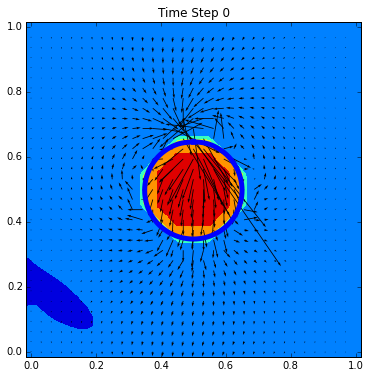

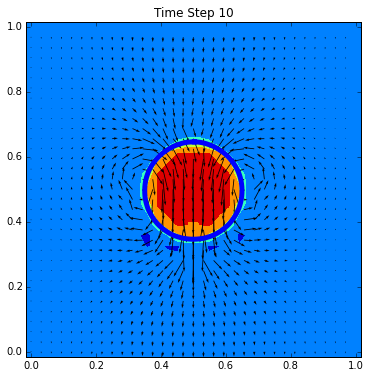

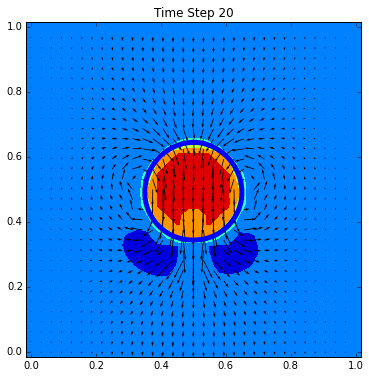

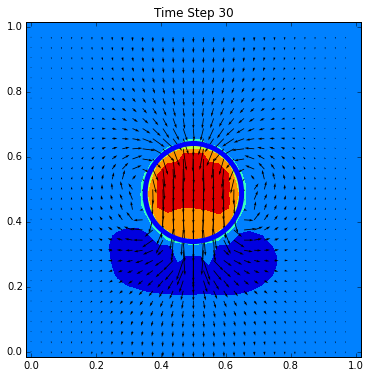

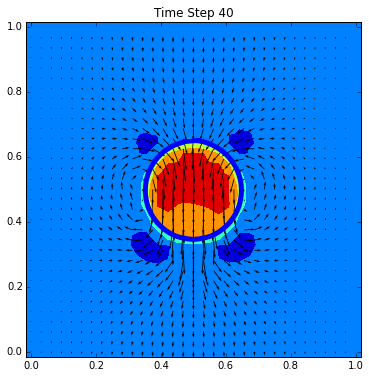

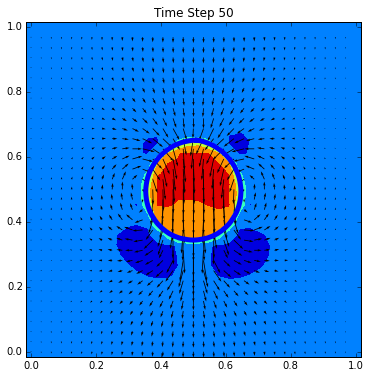

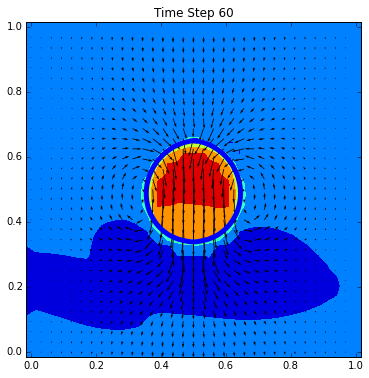

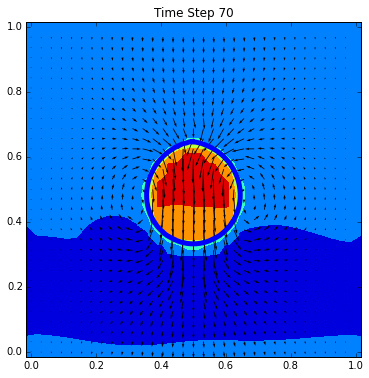

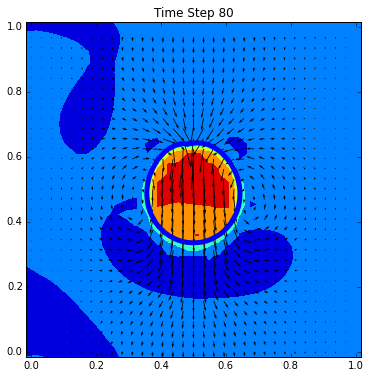

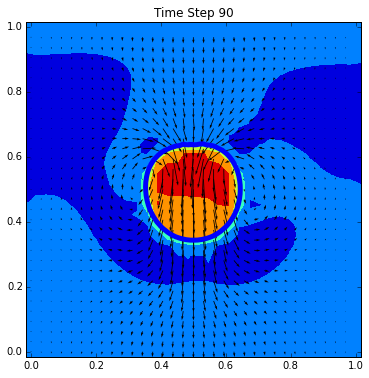

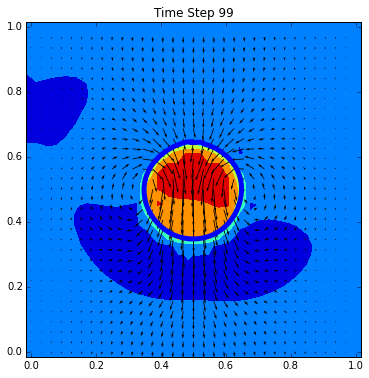

In [14]:
#Domain size and constant parameters
Lx=1.0; Ly=1.0
gx=0.0; gy=-100.0;
rho1=1.0; rho2=2.0
m1=0.01
m2=0.05
rro=rho1;
sigma=10.0

#Velocity at wall boundary
unorth=0; usouth=0; veast=0; vwest=0; 

#Initial drop size and location
time=0.0; rad=0.15; xc=0.5; yc=0.5;

#Numerical variables
nx=32; ny=32;
dt=0.00125; nstep=100
maxiter=200; maxError=0.001
beta=1.2;

solveperiodic()